# introduction

This file tests the **wind power forecasting** for the [Global Energy Forecasting Competition 2012 - wind power Forecasting](https://www.kaggle.com/competitions/GEF2012-wind-forecasting/data).

`Goal`: 

- mimicking the operation 48-hour ahead prediction of hourly power generation at 7 wind farms

`Note`:

- 2009/7/1 and 2010/12/31 is a model identification and training period
- the remainder of the dataset, that is, from 2011/1/1 to 2012/6/28, is there for the evaluation
- The forecasting accuracy will be evaluated with a Root Mean Square Error (**RMSE**) criterion

`Data`:



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel, BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.callbacks import TFMProgressBar

In [2]:
from energy_forecasting.preprocess import remove_tailnan, check_missing
from energy_forecasting.modules import *
from energy_forecasting.params import Params
from energy_forecasting.modelling import eval_model

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
params = Params()

In [5]:
data = pd.read_csv('../data/raw/GEF2012-wind-forecasting/train.csv')

In [6]:
# chaining the functions below

In [7]:
data['Datetime'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [8]:
data = data.set_index('Datetime', drop=True)

In [9]:
data.head()

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
Datetime,,,,,,,,
2009-07-01 00:00:00,2009070100,0.045,0.233,0.494,0.105,0.056,0.118,0.051
2009-07-01 01:00:00,2009070101,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2009-07-01 02:00:00,2009070102,0.020,0.175,0.178,0.033,0.015,0.026,0.000
2009-07-01 03:00:00,2009070103,0.060,0.085,0.109,0.022,0.010,0.013,0.000
2009-07-01 04:00:00,2009070104,0.045,0.032,0.079,0.039,0.010,0.000,0.000


In [10]:
np.sum(data.isna())

/opt/anaconda3/envs/gpflow/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


date    0
wp1     0
wp2     0
wp3     0
wp4     0
wp5     0
wp6     0
wp7     0
dtype: int64

In [11]:
# select a certain wind farm, e.g. `wp1`
target = data['wp1']

In [12]:
target.shape[0]

18757

In [13]:
check_missing(target)

No of missing values left: 0


In [14]:
# create `TimeSeries` object

In [15]:
target = TimeSeries.from_series(target, freq='H')

(0.0, 1.0)

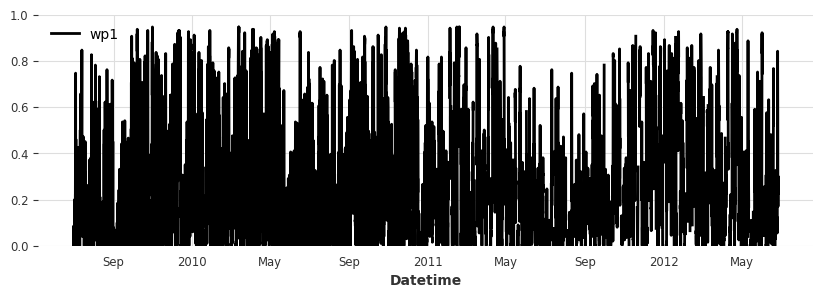

In [16]:
fig, ax = plt.subplots(figsize=params.figsize)
target.plot()
ax.set_ylim([0,1])

In [17]:
# read-in features (which are already normalised) accordingly w.r.t the wind farm
features = pd.read_csv('../data/raw/GEF2012-wind-forecasting/windforecasts_wf1.csv')

In [18]:
features.shape

(104832, 6)

In [19]:
features.tail()

,date,hors,u,v,ws,wd
104827,2012062612,44,2.44,1.08,2.67,66.14
104828,2012062612,45,2.11,1.46,2.57,55.39
104829,2012062612,46,1.63,1.61,2.29,45.42
104830,2012062612,47,1.07,1.58,1.91,34.05
104831,2012062612,48,0.53,1.48,1.58,19.68


In [20]:
# feature engineering a bit, create `future covariates`

In [21]:
filler = MissingValuesFiller()
target = filler.transform(target)

In [22]:
target = target[: pd.Timestamp('20101231')]

In [23]:
training_cutoff_wp = target.time_index[-(2 * params.forecast_horizon)]

In [24]:
training_cutoff_wp

Timestamp('2010-12-27 01:00:00')

In [25]:
train_wp, val_wp = target.split_before(training_cutoff_wp)

<Axes: xlabel='Datetime'>

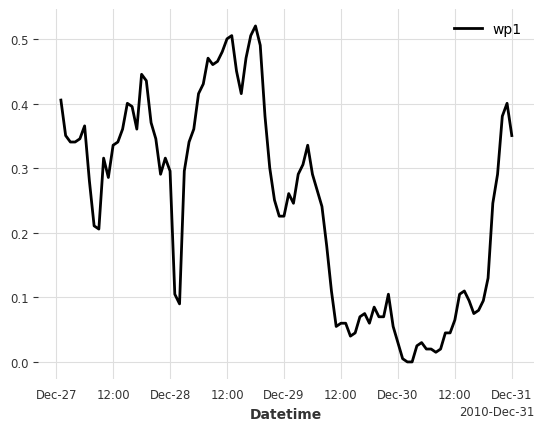

In [26]:
val_wp.plot()

In [27]:
# epochs set to 1 for illustration purpose

In [28]:
TFT_model = TFTModel(
    input_chunk_length=params.input_chunk_length,
    output_chunk_length=params.forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.5,
    batch_size=64,
    n_epochs=1,
    add_relative_index=False,
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["hour", "dayofweek"]},},
    random_state=42,
)

In [29]:
TFT_model.fit(
    train_wp, 
    verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 16.5 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 66.3 K
8  | static_cont

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.


TFTModel(hidden_size=128, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.5, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=144, output_chunk_length=48, batch_size=64, n_epochs=1, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}}, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

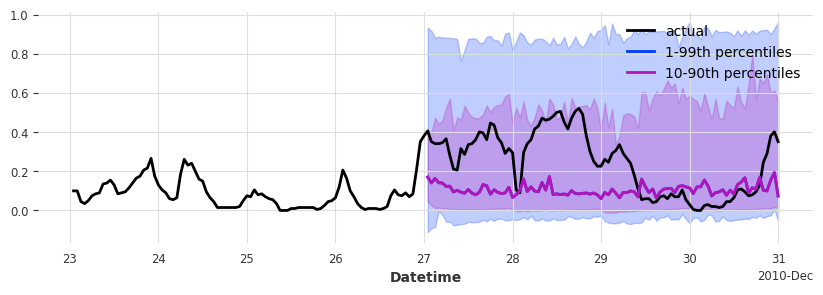

In [30]:
# validation
mape_TFT = eval_model(
                model = TFT_model, 
                n = 96, 
                actual_series = target[
                            train_wp.end_time() - (2 * 48 - 1) * train_wp.freq :], 
                val_series = val_wp)